In [3]:
import sys
sys.path.append('../')

import numpy as np

from fmodeling.ForwardProcessing1D import forward_with_trace_calcing
from Inversion.Strategies.SeismDiffInversion1D import inverse
from Inversion.Optimizators.Optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid_rp_dicts
from objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from objects.Models.Models import SeismicModel1D
from objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from objects.Attributes.Seismic.SeismicAttribute import SeismicAttribute
from objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from Inversion.Strategies.SeismDiffInversion1D import func_to_optimize


In [4]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    for val in val_x:
        errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))
        
    plt.plot(val_x, errs)
    if dot:
        plt.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        plt.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    plt.show()

def optimization_func_2D(forward_params, x, y):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            Z[ind1, ind2] = func_to_optimize([x[ind1, ind2], y[ind1, ind2]], placeholders, forward_params, helper=None, show_tol=False)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y)
    
    plt.contourf(X, Y, Z, ncontous, cmap='seismic')
    plt.colorbar()
    
    if points is not None:
        plt.plot(points[0], points[1], marker='x', color='r')

# 2-layered model

In [20]:
layer_1 = Layer1D(h,
                  rp_attribute=RockPhysicsAttribute(layer_1_dict["components"], layer_1_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

layer_2 = Layer1D(-1,
                  rp_attribute=RockPhysicsAttribute(layer_2_dict["components"], layer_2_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

NameError: name 'h' is not defined

In [ ]:
dx = 100
nx = 20
x_rec = [i * dx for i in range(1, nx)]
wave_types = [OWT.PdPu]

In [ ]:
model = SeismicModel1D([layer_1, layer_2])
model_true = SeismicModel1D([layer_1, layer_2])
model_opt = SeismicModel1D([layer_1, layer_2])

In [ ]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=3e-03, trace_len=1500, wavetypes=wave_types, display_stat=True,
        visualize_res=False)

In [ ]:
forward_params = {
    "model": model,
    "x_rec": x_rec,
    "dt": 3e-03,
    "trace_len": 1500,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

In [ ]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"]
    )

In [ ]:
optimizers = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
        factr=10000,
        maxls=50,
        epsilon=0.000001
    )
]

In [ ]:
optimizers = [
    DifferentialEvolution()
]

In [ ]:
forward_params['model'].layers[0]['Km'] = 10

In [ ]:
forward_params['model'].layers[1]['Km'] = 25

In [ ]:
forward_params['model'].layers[0].rp_attribute.vals_dict['Km']["optimize"] = True

In [ ]:
forward_params['model'].layers[1].rp_attribute.vals_dict['Km']["optimize"] = True

In [ ]:
inversed_model = inverse(optimizers, error=0.01, placeholders=placeholders, forward_params=forward_params)

In [ ]:
inversed_model

## Single variable opt

In [ ]:
from Inversion.Strategies.SeismDiffInversion1D import func_to_optimize

In [ ]:
forward_params['model'].layers[0].rp_attribute.vals_dict['Km']["optimize"] = False

In [ ]:
forward_params['model'].layers[1].rp_attribute.vals_dict['Km']["optimize"] = True

In [ ]:
forward_params['model'].layers[0]['Km'] = 7.3

In [ ]:
forward_params['model'].layers[1]['Km'] = 21.5

In [ ]:
forward_params['model'].get_optimization_option("val", vectorize=True)

In [ ]:
min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
max_val = forward_params['model'].get_optimization_option("max", vectorize=True)

In [ ]:
nvals = 30

In [ ]:
dval = (max_val - min_val) / nvals

val_x = [min_val + dval*i for i in range(nvals+1)]
errs = []
for val in val_x:
    errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))

In [ ]:
plt.plot(val_x, errs)

## Duo variable opt

In [ ]:
forward_params['model'].layers[1].rp_attribute.vals_dict['Km']["optimize"] = True

In [ ]:
forward_params['model'].get_optimization_option("val", vectorize=True)

In [ ]:
min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
max_val = forward_params['model'].get_optimization_option("max", vectorize=True)

In [ ]:
def f(x, y):
    return np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)


In [ ]:
dval = (max_val - min_val) / nvals

val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

X, Y = np.meshgrid(val_1_x, val_2_x)

Z = optimization_func_2D(X, Y)

In [ ]:
Z.shape

In [ ]:
X.shape

In [ ]:
plt.contourf(X, Y, Z, 10, cmap='cool')
plt.colorbar()

# 3-layered model

In [5]:
h = 1000

In [6]:
layer_1_dict, layer_2_dict, layer_3_dict = get_model_3layered_fluid_rp_dicts()

In [7]:
layer_3_1 = Layer1D(h,
                  rp_attribute=RockPhysicsAttribute(layer_1_dict["components"], layer_1_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

layer_3_2 = Layer1D(h,
                  rp_attribute=RockPhysicsAttribute(layer_2_dict["components"], layer_2_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

layer_3_3= Layer1D(-1,
                  rp_attribute=RockPhysicsAttribute(layer_3_dict["components"], layer_2_dict["name"]),
                  seism_attribute=None,
                  opt=LayerOPT.RP)

In [8]:
dx = 300
nx = 5
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu]
# wave_types = [OWT.PdPu, OWT.PdSVu]

In [9]:
model_3l = SeismicModel1D([layer_3_1, layer_3_2, layer_3_3])

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu-rays...
Drawing results...


ValueError: not enough values to unpack (expected 3, got 2)

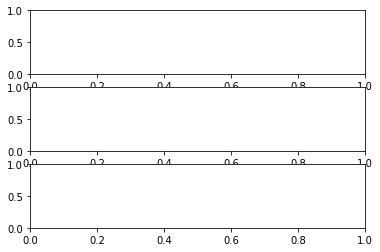

In [11]:
observe, test_seismic = \
    forward_with_trace_calcing(model_3l, x_rec,
                               dt=3e-03, trace_len=1500, wavetypes=wave_types, display_stat=True,
        visualize_res=True)

In [9]:
forward_params = {
    "model": model_3l,
    "x_rec": x_rec,
    "dt": 3e-03,
    "trace_len": 1500,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

In [10]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"]
    )

In [11]:
optimizers_lbfgs = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
#         factr=10000,
#         maxls=50,
#         epsilon=0.000001
    )
]

In [12]:
optimizers_cg = [
    ConjugateGradient()
]

In [13]:
optimizers_de = [
    DifferentialEvolution(
          popsize= 5,
          maxiter= 20000,
          init= "latinhypercube",
          strategy= "best1bin",
          disp= False,
          polish= False,
          tol= 0.00001,
          mutation= 1.5,
          recombination= 0.6,
          workers= 8
    )
]

In [14]:
optimizers_tc = [
    TrustConstr(
        opt_options={
            "initial_tr_radius": 0.7,
            "maxiter": 1000000
#             "gtol":1e-4,
        }
    ),
#     LBFGSBOptimization(
#         maxiter=15000,
#         maxfun=15000,
#         factr=10000,
#         maxls=50,
#         epsilon=0.000001
#     )
]

### Some model changes

In [ ]:
forward_params['model'].layers[0].rp_attribute.vals_dict['phi_s']['optimize'] = False
forward_params['model'].layers[0].rp_attribute.vals_dict['Kf']['optimize'] = False
forward_params['model'].layers[0].rp_attribute.vals_dict['rho_f']['optimize'] = False
forward_params['model'].layers[0].rp_attribute.vals_dict['phi']['optimize'] = False

forward_params['model'].layers[1].rp_attribute.vals_dict['phi_s']['optimize'] = False
forward_params['model'].layers[1].rp_attribute.vals_dict['Kf']['optimize'] = False
forward_params['model'].layers[1].rp_attribute.vals_dict['rho_f']['optimize'] = False
forward_params['model'].layers[1].rp_attribute.vals_dict['phi']['optimize'] = False

### Km optimization

In [15]:
opt_flag = True
# opt_flag = False
if opt_flag:
    forward_params['model'].layers[0]["Km"] = 9
    forward_params['model'].layers[0].opt = LayerOPT.RP
    forward_params['model'].layers[0].rp_attribute.vals_dict['Km']['optimize'] = True
    
else:
    forward_params['model'].layers[0]["Km"] = 7.3
    forward_params['model'].layers[0].opt = LayerOPT.NO
    forward_params['model'].layers[0].rp_attribute.vals_dict['Km']['optimize'] = False

opt_flag = True
# opt_flag = False

if opt_flag:
    forward_params['model'].layers[1]["Km"] = 25
    forward_params['model'].layers[1].opt = LayerOPT.RP
    forward_params['model'].layers[1].rp_attribute.vals_dict['Km']['optimize'] = True

else:
    # TRUE VALUE
    forward_params['model'].layers[1]["Km"] = 21.5
    forward_params['model'].layers[1].opt = LayerOPT.NO
    forward_params['model'].layers[1].rp_attribute.vals_dict['Km']['optimize'] = False



# opt_flag = True
opt_flag = False

if opt_flag:
    forward_params['model'].layers[2]["Km"] = 25
    forward_params['model'].layers[2].opt = LayerOPT.RP
    forward_params['model'].layers[2].rp_attribute.vals_dict['Km']['optimize'] = True

else:
    # TRUE VALUE
    forward_params['model'].layers[2]["Km"] = 22
    forward_params['model'].layers[2].opt = LayerOPT.NO
    forward_params['model'].layers[2].rp_attribute.vals_dict['Km']['optimize'] = False



### Gm optimization

In [21]:
# opt_flag = True
opt_flag = False
if opt_flag:
    forward_params['model'].layers[0]["Gm"] = 5
    forward_params['model'].layers[0].opt = LayerOPT.RP
    forward_params['model'].layers[0].rp_attribute.vals_dict['Gm']['optimize'] = True
    
else:
    forward_params['model'].layers[0]["Gm"] = 2.71
    forward_params['model'].layers[0].opt = LayerOPT.NO
    forward_params['model'].layers[0].rp_attribute.vals_dict['Gm']['optimize'] = False

# opt_flag = True
opt_flag = False

if opt_flag:
    forward_params['model'].layers[1]["Gm"] = 15
    forward_params['model'].layers[1].opt = LayerOPT.RP
    forward_params['model'].layers[1].rp_attribute.vals_dict['Gm']['optimize'] = True

else:
    # TRUE VALUE
    forward_params['model'].layers[1]["Gm"] = 17.5
    forward_params['model'].layers[1].opt = LayerOPT.NO
    forward_params['model'].layers[1].rp_attribute.vals_dict['Gm']['optimize'] = False



# opt_flag = True
opt_flag = False

if opt_flag:
    forward_params['model'].layers[2]["Gm"] = 15
    forward_params['model'].layers[2].opt = LayerOPT.RP
    forward_params['model'].layers[2].rp_attribute.vals_dict['Gm']['optimize'] = True

else:
    # TRUE VALUE
    forward_params['model'].layers[2]["Gm"] = 10.7
    forward_params['model'].layers[2].opt = LayerOPT.NO
    forward_params['model'].layers[2].rp_attribute.vals_dict['Gm']['optimize'] = False



NameError: name 'forward_params' is not defined

## Model calcing

In [16]:
forward_params['model'].get_optimization_option('val')

OrderedDict([(0, {'Km': 9}),
             (1,
              {'Km': 25,
               'phi_s': 0.05,
               'Kf': 1.8,
               'rho_f': 0.95,
               'phi': 0.1})])

In [17]:
# scale="minmax"
scale=None
start_time = time.time()
# optimizers_tc[0].opt_options["finite_diff_rel_step"] = 0.1
inversed_model = inverse(optimizers_tc, error=0.07, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"TC time: {time.time() - start_time}")

0.14651545438046212
0.14651545383051245
99999
0.1465154511795146
0.1465154545942669
0.14651545446906183
0.14651543860308203
0.14518164923740112
0.14518164870868291
0.14518165055241936
0.14518164613196727
0.14518164943529346
0.14518164932845443
0.14518163390264624
0.14606303841794188
0.14606303788663846
0.1460630397519434
0.14606303531048415
0.1460630386206438
0.14606303850857208
0.14606302308584007
0.1462217583326162
0.14622175779589217
0.14622175968726842
0.14622175519956385
0.14622175853864308
0.14622175842266488
0.1462217428722753
0.14636669791962187
0.14636669737661762
0.14636669929786073
0.1463666947552395
0.14636669812914152
0.14636669800897312
0.14636668231669864
0.14642237127450644
0.146422370728271
0.14642237266598224
0.14642236809337764
0.14642237148599724
0.14642237136351605
0.1464223555901963
0.14649625449387652
0.14649625394491683
0.14649625589571252
0.14649625129876637
0.14649625470687988
0.14649625458258989
0.14649623874699674
0.14646089091817796
0.14646089036969928
0.14

/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


0.14633733453827077
0.1463373364689769
0.14633733190602816
0.14633733529301418
0.1463373351716383
0.14633731942803715
0.14633733508234467
0.14633733453827077
0.1463373364689769
0.14633733190602816
0.14633733529301418
0.1463373351716383
0.14633731942803715
0.14633733508234467
0.14633733453827077
0.1463373364689769
0.14633733190602816
0.14633733529301418
0.1463373351716383
0.14633731942803715
0.14633733508234467
0.14633733453827077
0.1463373364689769
0.14633733190602816
0.14633733529301418
0.1463373351716383
0.14633731942803715
0.14633733508234467
0.14633733453827077
0.1463373364689769
0.14633733190602816
0.14633733529301418
0.1463373351716383
0.14633731942803715
0.14633733508234467
0.14633733453827077
0.1463373364689769
0.14633733190602816
0.14633733529301418
0.1463373351716383
0.14633731942803715
0.14633733508234467
0.14633733453827077
0.1463373364689769
0.14633733190602816
0.14633733529301418
0.1463373351716383
0.14633731942803715
0.14633733508234467
0.14633733453827077
0.146337336468

0.13239412663798417
0.1323941264496025
0.13239412621779484
0.13239412747911364
0.13239412656714486
0.13239412667903946
0.13239412981972992
0.13239412663798417
0.13239412644960252
0.13239412621779484
0.13239412747911364
0.13239412656714486
0.13239412667903944
0.13239412981972992
0.13155981844674555
0.13155981827334035
0.13155981802445751
0.13155981932024033
0.1315598183750773
0.13155981848958645
0.13155982170955438
0.13286033957420304
0.13286033935674454
0.13286033916374976
0.13286034036019065
0.13286033950568946


KeyboardInterrupt: 

In [18]:
# scale="minmax"
scale=None
start_time = time.time()
inversed_model = inverse(optimizers_de, error=0.01, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"DE time: {time.time() - start_time}")

/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:454: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


0.14205766581549692
0.15531066652944564
0.19747929449043267
0.11689840863437234
0.13348923273410127
0.14815620727296255
0.13615302382150157
0.14913759989285463
0.15422226905835937
0.17741280928449804
0.15189021791087787
0.1393451922236805
0.13645897966837944
0.2180945522331457
0.13410278943426046
0.12385056836571615
0.17934673895618547
0.19384146470562605
0.19751334988265412
0.1212420855507561
0.15047023266585266
0.132097505352178
0.15209904538424168
0.12944388826794398
0.20478372370051268
0.20868092849889608
0.12195823055057711
0.1706100692474743
0.16467774539842267
0.11032396113178206
0.11080073336886054
0.16750352320692075
0.1463879191564911
0.16006668003916039
0.14966703093646194
0.13557330957497826
0.15018581848821067
0.1361135998523392
0.1537692138871092
0.13619242019156405
0.19208168297043343
0.1531352715132953
0.15271619452921026
0.14168901010754661
0.1283796941099863
0.15735758661204613
0.13522957270116687
0.14081667908218698
0.143285478041259
0.19270157490363482
0.11495345820

0.11178812153249237
0.13942594972419506
0.13190066157327296
0.11414141681704491
0.10298805934563363
0.1348666862648276
0.12122091911429686
0.10971958913012023
0.18573710342083932
0.10228361316044426
0.10513101583095606
0.1882747632559954
0.10723482103956858
0.14768995859604345
0.11275974855820556
0.14631789566972464
0.1631104840865219
0.14396143426005942
0.15191641394673508
0.12307074296703235
0.12410708300479152
0.08583220824737067
0.12586240909833862
0.12131012449880538
0.12021542209648572
0.06547419882013815
0.13354021040989872
0.1508040696446173
0.21345935821088374
0.17233398276839695
0.17593508296400912
0.1552089844857688
0.06863433818067526
0.15309241225266687
0.11053814034760234
0.12243622445103422
0.09311882682339839
0.152706289679449
0.1142385396703671
0.14410225022075362
0.10531662899210428
0.09403996460887798
0.15704332673501264
0.1459154145515668
0.09824754326602533
0.11904365036130851
0.11050611126242527
0.17303631434179817
0.11041433811491107
0.1308792148993558
0.14140569

0.12699392988056285
0.06608541168921739
0.10965577821274733
0.11087968582731256
0.14189899863900224
0.11768022138240689
0.10001295532429909
0.10177111046999517
0.10660110534581162
0.13047291439907938
0.11680178967110309
0.11222884141545036
0.0624208985685787
0.09053393085916459
0.1011657078586137
0.10126711312602452
0.13176689189145868
0.08814719323091566
0.06909147929554027
0.0831994444253122
0.16262094010099462
0.08171735658228187
0.12240904602683234
0.06796882904720528
0.09751324913124998
0.11512979407424269
0.14700825625429165
0.08770657238120354
0.14292394884388498
0.09738128281572625
0.11427068382313404
0.1480355951278362
0.1169923410826113
0.107151398959003
0.14048497608389757
0.09745563925934936
0.08676581286319693
0.1274241541625548
0.07551813627197676
0.1297347633599055
0.14249787991290053
0.1383263765874021
0.13386154470849704
0.09103078788850277
0.13817730668693648
0.07248858225918475
0.07086674815657756
0.1046995335411113
0.12169440559505718
0.08931431329783507
0.118368129

0.11306830294866695
0.07554601342730555
0.10334873028479938
0.08065697845675114
0.11146340453181613
0.11430237017939546
0.11208598465087347
0.06257147357051707
0.10226764435739603
0.11597230453322617
0.10390768979736167
0.08262669200818423
0.1157984654495303
0.08474066580076492
0.05781938317803786
0.10525505144196873
0.10129806652010037
0.08129454280533915
0.10410256962053774
0.10095655832892683
0.1091204777301468
0.08383782162059072
0.14331149561028753
0.06308018185019784
0.10786939313482363
0.06985842813853077
0.11631255253981462
0.09087129461144955
0.11416013132857913
0.1087929048270057
0.09585654681087377
0.10327372031090326
0.09438180226782569
0.10515415321605251
0.11405904006977717
0.0774190394984727
0.06985955842010973
0.10876116382455059
0.09884824126113774
0.09085110984789461
0.10663183077298746
0.09824628694240758
0.06476812168957091
0.10863496091154515
0.08003650436188654
0.06069071928505048
0.10613729377298992
0.0965243343419836
0.10848104676133874
0.09516026317276113
0.111

0.08678196194651973
0.07696342048674452
0.129921054614811
0.10381780963097914
0.08671285217791705
0.12895510682577505
0.10588520298686496
0.1332191005776821
0.09112367910087225
0.07154468396372111
0.07140810686917859
0.07286307327307676
0.06541335757728867
0.06023306754942131
0.06820915361341495
0.08159268313600275
0.1296117012258641
0.10732904413362629
0.06976633126178948
0.09489620019623962
0.11501412407911886
0.1179764027162992
0.10735197764716992
0.07063699999272467
0.06762868736202737
0.11585506737728463
0.0717418336601862
0.11177230014823263
0.06125263309424704
0.07576694372121225
0.06375624877836404
0.06905945585686182
0.09368522756996082
0.06956464526602353
0.08902166326631028
0.09102894141913159
0.10795832640619415
0.13661635940289946
0.08577690228156046
0.11707682495907384
0.07475514324881083
0.07137903453301521
0.08352321417896554
0.06447846675912394
0.0649740110525586
0.07761177796476763
0.06560300800592486
0.0748574462650371
0.06796467546724638
0.07547035474152605
0.105462

0.07951029383720565
0.09717537352035263
0.08112474006123449
0.11657816619932607
0.12610256053583152
0.11849757429491828
0.11585691422601056
0.06551357731702954
0.10578423770084167
0.09479647817356551
0.09315080427830635
0.0701086460851795
0.1254542423060674
0.11132053795387367
0.0829539718217135
0.10684424345120802
0.08096252607330412
0.08373795287271805
0.069740839284208
0.09666522698778501
0.07050671026755506
0.06097495973475613
0.07591448258654833
0.07542949339421287
0.0995091027790543
0.1194033300352238
0.10420353454619924
0.08860728393645842
0.06168249949428053
0.07119910452790264
0.11072837508107483
0.08607282837795875
0.07018588571562503
0.1022785987724937
0.07799426994631799
0.0663605030808415
0.12683898925325432
0.07243567722282232
0.10968843011069677
0.07818188394670558
0.09859891937511418
0.11128837451160278
0.10057442394203112
0.07342425416986537
0.05815934541700488
0.07070553544310237
0.11052158888525337
0.07713525166829316
0.1274188053643777
0.12163198900470512
0.07559962

0.05930704884063187
0.10131158955793079
0.058188420788018655
0.1339166085543934
0.09709424618371254
0.06683090243881194
0.062328705253906366
0.07564187121343055
0.07732764228058717
0.1022096196361933
0.10466356852910749
0.10293855946458787
0.09917396674599782
0.10925225738862415
0.10588971222755553
0.09867142761286526
0.07896957196598758
0.05968691880870496
0.10313484344015637
0.05616075260680377
0.1196497051546862
0.08555652402948248
0.07112430277228238
0.06361088297193097
0.08175377858436347
0.10874942067229401
0.11313180776800988
0.055173874480914126
0.09424536077735146
0.0908961115683973
0.10721594740130919
0.09343975083259878
0.07400309208027489
0.10719569284948907
0.06783354036752408
0.06487755362783246
0.10831309791393182
0.13295308842153475
0.0944366095592692
0.056814190707274746
0.11340390975280956
0.09758295902260222
0.0774481066007036
0.06378646581400423
0.10407536187276775
0.11753565320051647
0.05348590611519382
0.06666341483140784
0.12981256545181263
0.06330319170303514
0.

0.06894646103505676
0.09883123409374046
0.11514074344791606
0.06848955890940395
0.0810503806017153
0.06869321536113879
0.09497917208937329
0.07696835054501035
0.08240762843697255
0.10300969149977707
0.10456518073557458
0.06636139152342087
0.11107090746898436
0.10295410595241541
0.10196611747663986
0.09799545378064523
0.10248028976483187
0.10550825652796914
0.07460558919247645
0.07869962309425627
0.07520258633837129
0.07288514493537904
0.05977487321625692
0.05724902452866595
0.11052668027150467
0.0709611561215999
0.08607854211579813
0.06580741480241216
0.1072787773344522
0.11202308763502428
0.11643708290385639
0.06490948168497042
0.09573279534911236
0.10520324725783
0.09205745180178046
0.08991028691577693
0.06546088956518478
0.08418446975265023
0.09685525595643682
0.06247106370661808
0.07580211500754203
0.10948254086963737
0.0790020753569611
0.06389173322513957
0.08186790495677439
0.1112181316333607
0.0737583868235597
0.08382399678269081
0.10465675721986072
0.10366051069170823
0.0710947

0.07317058688276165
0.11057776601881394
0.058927881454955054
0.07459495721823182
0.0849581028496551
0.12495016911733887
0.06938296841722669
0.0993211768116117
0.0921445951404507
0.08197998070867288
0.06711847128735882
0.0668347587525015
0.10080895836127576
0.06785022257561706
0.10101816746243567
0.11411191244417188
0.05561730139897299
0.070995504368537
0.12518841761470179
0.08748904787043954
0.06561037426966435
0.09997660985202647
0.11091632676784809
0.06053140338419249
0.12506017946518716
0.12712531946449437
0.07727809751838696
0.10796477413861165
0.06118881396418229
0.10828909614442542
0.11524172158137175
0.062163238786304004
0.08094853631739338
0.10767477468039233
0.0761899051946633
0.10604864433786029
0.08478180190055765
0.06916859258225935
0.06458903600523704
0.09171676008381467
0.09453478073622802
0.06451495686553232
0.08916356328950631
0.08699798386963586
0.07737298559774161
0.06133580710413645
0.06937116014450659
0.10807819862711353
0.08796019763459456
0.10317923706532472
0.087

0.12646689941998948
0.09446812857170513
0.0534160977661705
0.09822124519075295
0.06679971185993086
0.10365701649557407
0.11426194357635526
0.07418419116782282
0.10197026162041153
0.1102214089486114
0.07370698619423073
0.06388894575671666
0.1032762968701747
0.09108666581537116
0.1269149289746535
0.08742519506727345
0.05929634732936785
0.06580866333315556
0.09010285374672747
0.061143753544879505
0.06514961461971494
0.06732077279306461
0.08856842663452827
0.0873578999584938
0.06972060681397957
0.10862454438551108
0.11524491040731905
0.07134958436055924
0.06682731982974635
0.08557486492225137
0.06874730680335432
0.09857856680333221
0.11147149120376545
0.07792181423151956
0.10739953352534076
0.064518364258636
0.08896832442071007
0.1153222827101429
0.11421728324514548
0.10193757749692575
0.11183973213298369
0.08933133240935985
0.07582538558577082
0.10695437344144415
0.11117082487745851
0.05874494304340718
0.09825668733571391
0.09557565792104823
0.0709078098242314
0.07828103536518508
0.080702

0.09163635409660817
0.07129437818175197
0.11100243642025227
0.10299621115050564
0.11115314555805028
0.13095348709874524
0.10432542650204472
0.055488001381373955
0.11914357965172351
0.06896459095353133
0.09789940403897662
0.12648467604283378
0.10260648659412286
0.06540207479932526
0.07616322519270298
0.0759620326291964
0.07039459534194142
0.0566762252517447
0.08994560719203604
0.1285058501974378
0.0783183423553878
0.1270467947426982
0.10795288313236094
0.07453624309831622
0.08459647052633316
0.1075735395083178
0.0807069557541542
0.06787420166423896
0.07781854044143405
0.06034333067823782
0.12734368232025628
0.06437820980622427
0.11055317534023269
0.06563365614942113
0.07962345947370633
0.10020194632664556
0.10185757477492435
0.07746200555226562
0.10421732130357778
0.11050567873322767
0.11176573498595865
0.06371016362595447
0.06920256872091322
0.08520272788160793
0.06434359212714744
0.08801547776969057
0.07498880143555771
0.10255937747190574
0.05979778558146188
0.10654243190527438
0.1155

0.10116577725962964
0.07398047847788745
0.10217436600119817
0.08022726464699498
0.0812273484570053
0.09168210578356988
0.08537622050196143
0.0590752897661492
0.0617269086477433
0.09163545875030744
0.07431570717904795
0.11133872879242507
0.11304487156308288
0.07958062383720141
0.0810976680253899
0.10781213363830497
0.06553264065110762
0.07172990810984388
0.10071039703460907
0.08435179222443173
0.06695013406498904
0.08507391712817503
0.11950536100065737
0.10789887575783833
0.09303326810279372
0.10471854770247047
0.10130163000229384
0.07229021806773686
0.06244253446580219
0.1258591658220134
0.0880086365502389
0.12373663067757196
0.08991403204990644
0.10570227003627745
0.06311647469010283
0.1081308964642907
0.06579070151567644
0.11030418231114703
0.07839184809034952
0.06335121122460684
0.09276871781811527
0.07391158231184738
0.06021492402330811
0.09643494665609621
0.06935126954657243
0.06960523079575745
0.08755252999283773
0.07683915337679403
0.07697875582412952
0.11381695462740202
0.06412

0.05986387149973407
0.09052939058783299
0.07529364552392839
0.09237759304593873
0.10803213951572586
0.0923203260877899
0.07448268178745104
0.08236582942963075
0.10691061134708496
0.1056838989352871
0.06753130997310361
0.08167679403503145
0.12397243526889101
0.1348478299748628
0.09963993885147654
0.08655565932979986
0.06396629360535734
0.08938264002952227
0.13149288149397426
0.07527968875069031
0.08032150926235912
0.08816210651404766
0.05911748235166123
0.09728270961375393
0.09361722221577484
0.08932902904785006
0.11004594543591223
0.10552017560535096
0.09583061920946512
0.09349833029927847
0.13347816234347956
0.10751324715474195
0.07967843914818606
0.07786705752191819
0.06729116038470143
0.07264406373886234
0.09435275081514954
0.08770878819041791
0.11642460581932038
0.09326104180308782
0.10582893732104229
0.08905488799980386
0.10711824432305503
0.12408521026993308
0.08117299641969036
0.11359096663723811
0.05845721898406034
0.06752719737481136
0.13071238455443762
0.06485170752277432
0.1

0.06831401370167721
0.07172275431934352
0.0766026163154977
0.07208326549070204
0.11470975629273612
0.1005540638576846
0.0629272752685862
0.07117633540498922
0.09317695661505879
0.05882058524580622
0.10625613371238228
0.1029706414328747
0.07446657209086824
0.06164419600691331
0.10843842625084615
0.10562164232640439
0.12283955223221132
0.10578707182595044
0.05920017347246659
0.062124738961822606
0.11817179029822783
0.06753015357251979
0.0896407395967481
0.11659018404166635
0.12589592736375574
0.08920776927132221
0.11349408184238892
0.12261204085812931
0.061116981460884304
0.08689300622405076
0.1152075059262229
0.059967327207756126
0.06758489703712323
0.06630051962624017
0.10997482129378272
0.10981268565570827
0.11318940501870298
0.09866237137491107
0.0944542459035328
0.0667548157018315
0.09602914421962408
0.1138638798058238
0.12525839452340903
0.06139235649207092
0.0705964329447872
0.06528889861396596
0.1085815049444868
0.11111936495846672
0.06929012593087024
0.06856751377772351
0.080304

0.06836181755296913
0.05803775036029689
0.11360527084318797
0.1151871617707701
0.10889980215120965
0.06550893204126979
0.10240744730399576
0.06830637131627064
0.0621485600521427
0.09909979993243791
0.08547570139770483
0.08391355430249195
0.09056949914834568
0.10912321323408346
0.08859516751438563
0.1058284255209775
0.09751884151148466
0.08260724062238672
0.08949535645639856
0.10038542399793485
0.10015473804108704
0.06157285701954803
0.10472069722006278
0.07623704758753491
0.08177804884802105
0.08112282904688285
0.08628261296131563
0.07854108551995631
0.1068209573924701
0.08639674941638417
0.08657606515609519
0.11563256164504479
0.10965559875687807
0.06152261732339332
0.06653223926981883
0.12780423472166197
0.09117357853002728
0.07302691483730797
0.10024698381292306
0.06229821984527065
0.09378776170382258
0.06717888107805586
0.11042546721792021
0.10932950393912473
0.06862987126783812
0.06894254023959259
0.08163174126898387
0.08995615467459615
0.06125201353580253
0.08613384049846487
0.07

0.06932260540386267
0.1063439079955666
0.06976531797931401
0.10995950137126409
0.0749806134917822
0.06579070151567644
0.09100821575918215
0.10538113258846857
0.10798730069493989
0.05765626573148154
0.060575333256751004
0.107704547909211
0.0932501391567965
0.058498368390310446
0.0675728428467715
0.08249764373889189
0.10487203211655835
0.08779843662923585
0.06887747880945286
0.11002464852837607
0.09126483715126912
0.06843708360582447
0.10736442229967494
0.06973254012179789
0.06800065277873359
0.08529702858514139
0.09442064952366026
0.09016842098205848
0.11604934004090556
0.09061266785204886
0.09969747348206144
0.08583961215094471
0.06372659123891862
0.062390674500252666
0.10575220051008276
0.06392849309371755
0.1070553730095665
0.0592840711937785
0.06355035863687443
0.08135863495073116
0.06939733393742543
0.07898993385732589
0.05556837450128691
0.1082822016677755
0.09021974767457425
0.06122394194817092
0.07472979478788985
0.08363570491737726
0.05913363823537385
0.06477648115028596
0.1116

0.12861723105259332
0.06444580681677652
0.09621774734101482
0.1033085512098805
0.10846653887376323
0.09036209267079498
0.1283707249460196
0.10336813700482884
0.07947760486560132
0.10768257027359665
0.0636719021294406
0.06483635248883798
0.11331889992815859
0.10585295856656238
0.07890036304987243
0.07805363679191635
0.09419968670868699
0.07540947780559451
0.10161351125707857
0.06050208809473892
0.12816864430715436
0.10324105641681784
0.100843293264263
0.13085531711792064
0.06766643682777429
0.059856845744779695
0.10861898580929091
0.09550369172414086
0.07567470842485953
0.080784053743964
0.08219026678336724
0.09325346634219506
0.10808738142834408
0.07077459593698082
0.07955115542744604
0.065318499183215
0.09667721186261344
0.11169453821091821
0.10887675223880829
0.10103637579236223
0.07798111938092918
0.05926973083513497
0.10944272578963046
0.06011068163845567
0.1145027637508886
0.09182263923993571
0.11165433178753931
0.1108432581394725
0.07779431705725462
0.12011039273292873
0.06156267

0.10640949935680666
0.08228407859789028
0.08375385899234075
0.10393072298842336
0.11402398031194463
0.07587607787375536
0.07473022671514662
0.07331283951221412
0.05690926017564676
0.06857493022844904
0.11386656294531383
0.10790383494948792
0.09424637965902757
0.10505750798701399
0.08260577799472843
0.0780676092271314
0.11935476954320837
0.07678452202446845
0.09198150733901339
0.06218651087646202
0.13029876762335768
0.09935426221480514
0.09838063735616762
0.06089250504094995
0.0673415268944945
0.14234078010953072
0.11074332019980165
0.07371888898017462
0.10535642134159331
0.1134898782766465
0.11058000777393276
0.08817830268829278
0.05677830539636972
0.06759795848747994
0.07288166621313724
0.061572832827396916
0.10923046123374702
0.10526744145997932
0.109253110637084
0.11131213966038742
0.063420276460147
0.08417811877858765
0.11729161021931114
0.10366119439176674
0.09216736620066587
0.11355213541723692
0.11459200808048095
0.11170208020634877
0.06548353254175457
0.10689147921776368
0.0908

0.1062973844441972
0.11248328251269521
0.06541961014885805
0.09085641701498176
0.1049399238516378
0.10019640292929186
0.09357804248791851
0.06650742304831492
0.06909073579778643
0.14032912626318228
0.09691698795776033
0.10254825768134417
0.06570206694989514
0.10847075915139745
0.088261749557526
0.060618027926625344
0.08668404542605218
0.08935127260274342
0.06868311405490372
0.07404802184440774
0.13552063245136833
0.09335032162771417
0.06933429310574094
0.06441310674394765
0.07064682342633644
0.1338636427964976
0.10917114037847228
0.11719425312771845
0.11601953103637869
0.10132800346521448
0.06920051855614348
0.06830983405508959
0.11664315768786546
0.07328749367101714
0.06071480333354966
0.07734594009429117
0.1266126025220207
0.07961380193783017
0.06866538831555379
0.09421465482897723
0.0933993315510511
0.08738794153571633
0.13805789739839186
0.11047026157147302
0.086611778086191
0.0996361204465759
0.10953053221280826
0.095410489322626
0.0683086705398345
0.05551048019153736
0.1075624102

0.10295817075412195
0.06780904183165927
0.08443768546763519
0.09806934021959776
0.07271142058265773
0.08251449302844706
0.1158181551189684
0.11637888921468792
0.10495618351151488
0.1141590189178792
0.06747154472562318
0.08831127797416662
0.07615153757825519
0.08045002581633551
0.10611344164335632
0.07161878579553559
0.10957071318585118
0.10989877035168014
0.10105264275777294
0.085023627080536
0.0989358079148552
0.0654137348231671
0.06445408502437422
0.05729097102784719
0.09105349690539706
0.10935508470214798
0.0717792683758874
0.06927524461001315
0.08287649515459539
0.06517257951821756
0.09927492011852668
0.08873617252515792
0.09513929039743639
0.06787802653642325
0.09352454396606238
0.07436895879962449
0.10859405634525622
0.0887713220331976
0.06630018405181701
0.11047302431056538
0.05753582128169257
0.05841249625550477
0.10524970942817036
0.060941525140933525
0.08793937529157134
0.13241547815636745
0.10253837332015317
0.09604411230182636
0.07600275702619444
0.06716956606722076
0.11591

0.07385357826987704
0.07308660242227337
0.07302926852559978
0.0659924542325153
0.1020575143642186
0.06605394213444477
0.10476014523956806
0.1090370413917974
0.09953400958750282
0.0913326121511216
0.10886971361917827
0.06850221333142298
0.05465979136719594
0.09281101176716569
0.10451056256487126
0.10349931874103785
0.12925181958214235
0.057771095149119614
0.07044114528138914
0.09609965200378898
0.10331265484839179
0.07971039856458195
0.1114346556521041
0.0671181930094537
0.11098785360192526
0.06386288174303587
0.08954398426128837
0.0917324435461267
0.11320768301346032
0.06016849470906917
0.07334996961291204
0.0994865004967812
0.0955441119051944
0.08210643536794117
0.05744781792020751
0.08541581947962226
0.12656103728739931
0.10967247117423451
0.10649284053405908
0.07493105982526212
0.10556874122792673
0.08896293292904964
0.06258131028705168
0.06060493920364604
0.09041200163028648
0.06066014024159839
0.10012169384482175
0.08809906718548169
0.05980974917477412
0.10452764243065779
0.060132

0.10314223986205406
0.0955592074034061
0.08777885313500933
0.08338580577189972
0.055184134837099934
0.05998488340833935
0.06469932513258556
0.06772343716977497
0.06683905867408761
0.0651146428571067
0.1130476684012782
0.10985879940225751
0.071868500238846
0.07405841093545759
0.09177876218351662
0.08347915151699714
0.1074385227137363
0.1062210868574209
0.10289757741460155
0.1119714678788295
0.10925339153535442
0.0635413955149951
0.06466767897241966
0.06879975488573482
0.10439361485403424
0.07979691915104321
0.1383134234038695
0.08742032400756647
0.0791453007138731
0.11606851439506038
0.09566957694018088
0.0753867391378755
0.07995714069979341
0.09412232494430411
0.11024172515952121
0.08060544844636917
0.10839102176471532
0.059273658462895305
0.08956454753268492
0.11141044775661033
0.09752489084637721
0.10600034571944347
0.06729112173356978
0.0692839892342576
0.06851561074058446
0.1316681662287041
0.11280395439359961
0.07888518736926184
0.10657223419775157
0.1105751588009762
0.07073041851

0.08679981930061366
0.06303795252914653
0.11115019190030373
0.07040773070187481
0.09243427308186189
0.10194713500850545
0.13579363110125725
0.06396265272214889
0.10719393887670045
0.08062403917946093
0.05807658983685501
0.055347837108391834
0.0779945651300509
0.09135230307533511
0.05246035422056924
0.10515676682966212
0.1022199545723377
0.06755195795525502
0.10556048929602467
0.11419283101189663
0.07254988787396403
0.09765363272967449
0.07960704943908775
0.11170605079573534
0.06014857142464636
0.0913895694615489
0.11507662823662879
0.1025231204832252
0.11079258655934093
0.06508094748645107
0.09083325173531538
0.057584781443153085
0.07599542132091625
0.0764974432190216
0.07897882137194401
0.10577043970087407
0.09632252990913406
0.062010866730542145
0.07306260857831234
0.08358577265366439
0.08996660920716917
0.09037558683636539
0.11496183455875175
0.05629693974580158
0.08326479042292241
0.07725685113160538
0.09830719248120667
0.06938991327257209
0.06385609369081653
0.0643068192842029
0.1

0.13150733812804838
0.11111592971754278
0.10566728815513118
0.08558248937221993
0.07960156913988124
0.1143848202069475
0.09201544705517214
0.08301949506579298
0.08929245457217784
0.12675025142367757
0.07978060888600674
0.07673660337388337
0.05814137870248292
0.10815376188783316
0.06839305728724823
0.07446008090287073
0.14528673124259167
0.07348724500644477
0.08310102579952207
0.0872608602171227
0.06192434997667412
0.11502689980581719
0.08034620875407489
0.07175458558415104
0.060701247572581864
0.06311276304971063
0.11336940490437826
0.12743526211847647
0.13391757195864684
0.055904330906504054
0.08270308485143814
0.11662487805453772
0.0732250097912992
0.09461451631654155
0.09514247350912844
0.062380666861677654
0.07256244879204164
0.13083391537415892
0.06740206811897607
0.05955638740664539
0.0927432509208339
0.06492687297340324
0.06358254291525473
0.061444428457970234
0.08744223530149145
0.06605568878667546
0.1121220728798524
0.061837418465943206
0.06225527959729239
0.11258772655521349


0.1308756752354531
0.07940970458765641
0.1047272515952586
0.07084744384436828
0.058911833193117207
0.06558324840463539
0.059382467383485134
0.13831248821959075
0.07937700549858132
0.14335718082814428
0.06855814310670025
0.054812843621742775
0.0974336798381713
0.06922764711513085
0.05564155366259801
0.12753408273810657
0.09464803803147581
0.06677627338940503
0.09166682131792861
0.12441584086703712
0.06795026602552416
0.0669026120847822
0.13147314331220025
0.06011845895501802
0.061063074819467766
0.062087082754490146
0.09092532177270378
0.08612213356759832
0.056837197050826
0.10138782431586456
0.11578384379250706
0.07507157526925148
0.07075279787217797
0.08545211925093449
0.10371060651588553
0.10600451971026245
0.13598331839170535
0.07888083874616994
0.060156801976054906
0.06897327144547218
0.05958986700850633
0.06920900555585097
0.08062987005139365
0.08331471964563725
0.06209424195299244
0.09351106942390112
0.07027201804476324
0.07663317480542531
0.07389464293257042
0.07452913903594226


0.05687022841414156
0.12304966248143201
0.12020915593035811
0.10844713145864668
0.11520431743130713
0.11359951207234968
0.1130723381482028
0.07534887325130449
0.07019647624974171
0.0797514953613544
0.09325733423335543
0.06556085061155636
0.05766380355156849
0.08314058928245846
0.11260966528173308
0.10364322713921356
0.09827752824143245
0.10477198955183555
0.10901767567235834
0.1324567668096177
0.0776872571462143
0.06041058826020719
0.0579275880338287
0.08427303986325826
0.07938693346138168
0.1127263347477615
0.11131774341438053
0.06840687016051625
0.09964832957621217
0.06293005854270697
0.06975047575368791
0.13124379201333
0.09247474801919603
0.10373467344179549
0.06632809966776063
0.07492899405642549
0.09533136021155952
0.06435048450094595
0.07077334799199907
0.07963963133662563
0.07978088518074129
0.10123199244774242
0.11012399381783569
0.07547381056474907
0.09993333132241658
0.10540852024009292
0.08210642946115224
0.11415037933530073
0.11244520894868183
0.05801744576435503
0.1065336

0.0967112216495696
0.07401284133132598
0.13410833291437785
0.06323991153707961
0.07921752723510322
0.08572726643892498
0.10610001227155562
0.0759307762900585
0.09573283135349242
0.09164047953848595
0.05582699932954972
0.06504625997873388
0.07416441005451806
0.10738763061667453
0.08225370523792504
0.06715962050267507
0.06074542865148115
0.06356790602363169
0.10405176768239296
0.10592384345590755
0.12644974761545058
0.07924046237937185
0.07284238752421329
0.07641279346225598
0.09968871143214011
0.07280940222198949
0.13735266227179438
0.08663790593565962
0.07164795759459397
0.07496043617373854
0.07564911308225947
0.05624794416920688
0.10845655103880866
0.08531667476389806
0.05738405485519158
0.06980133875636811
0.06182771749327332
0.1254120148964902
0.09631990965567613
0.09118546148154281
0.097806476060306
0.09153556048472906
0.07917993383496329
0.0935141660352524
0.06365165844963343
0.0927314043142041
0.10213563242426787
0.08487430079318792
0.12550841798231954
0.0915042854531474
0.123573

0.08810558331842103
0.1317962843406414
0.11532758183521788
0.059908201781379906
0.09836489084780385
0.08265058641579348
0.09257146289712527
0.07311971976392168
0.07046137527001484
0.11025551963845037
0.052355506678555264
0.05982541212955305
0.061705633525357954
0.06710490717836054
0.07231731399129876
0.0964714493930044
0.05533864570751116
0.10320786864828593
0.12390071188566881
0.07858119317529616
0.07000262036296495
0.07476593902016626
0.06380267132615017
0.054290106506576806
0.10788334576427608
0.11030713666995914
0.058570156729952104
0.08130622143218515
0.09538780188274455
0.1018622344820504
0.10734293245529607
0.060239301991326016
0.10600372422908347
0.06378512983434018
0.09823768314113006
0.06361811713073415
0.06281032118066115
0.08864332583320061
0.06552581960119402
0.11535575196187908
0.09545466321277779
0.1032224269272101
0.07878840952617557
0.11009738134647637
0.06337192593452119
0.1285046527469283
0.07913629724300819
0.09565408382462284
0.09421508584331917
0.10967965184698886

0.10753438513000532
0.06662538505716999
0.1121863653928695
0.07969141982403913
0.06343432910898422
0.07169610923138975
0.10983383513567035
0.07907620088339797
0.10551754328035617
0.06488992939596043
0.0925332249787913
0.05379548572830154
0.09892126121079686
0.06798267551800743
0.09723970190162974
0.10929471797864927
0.11110166217139075
0.06406755314543365
0.08743783067728994
0.0557471235944242
0.08178292960358123
0.11153739639051577
0.07058607592532377
0.06855479195412052
0.08638079747190477
0.10734991537555146
0.0579496308201122
0.08165133231039746
0.09386867752894693
0.07404019310095747
0.107466498987827
0.11213519743245356
0.08486101311719686
0.06889213816360404
0.1154107207459524
0.06312937927698462
0.05627123216403641
0.11138866706129916
0.11564253802669283
0.07320483616663788
0.07093201399171407
0.11091226310438862
0.10890130199740464
0.0684493140970132
0.07440833031572966
0.06298277543697506
0.06619563000897856
0.0754913625051708
0.07336881490176914
0.09433399110791192
0.0763792

0.05777810417154651
0.07421893940476386
0.07364718054073245
0.07141590898534904
0.06083070602239618
0.10704602313094214
0.08839407387191342
0.05844166718388328
0.05528390172422514
0.10815817741324515
0.07141474865139641
0.05639096553483228
0.10000628878617313
0.0773485140834291
0.10796378513316082
0.08349643772156101
0.10862395100912872
0.07143808647992957
0.10845918069243146
0.09492545913013971
0.11054565082843812
0.10918011003328754
0.11208229180829272
0.1135023271409831
0.09607219990646199
0.1065585644011805
0.08540963219464787
0.1138586871407472
0.13076955868455822
0.06276795850108355
0.07707915991269454
0.06413884699591314
0.10939484000901152
0.10658743092905562
0.10331153199692497
0.05611132249777774
0.10565820644863691
0.08700091175908382
0.10926411856405002
0.1025164234743186
0.09179872084539237
0.10282359503065305
0.10562911701274906
0.10647890547189623
0.11436784064285493
0.06176718937667981
0.11261175927403261
0.05969713826698064
0.0713517739755038
0.0725901262885438
0.07101

0.09610261991622987
0.11045874758640473
0.09548734074094098
0.06155111969967169
0.09971428277893885
0.11452522009961208
0.10996045897576207
0.09861088967201828
0.10738486054436519
0.06651791330629293
0.11061274551913042
0.06371858057526063
0.10620165634328571
0.10923021122977307
0.09529924292653077
0.06909326693047285
0.10854403905229115
0.10084948428035201
0.07092748420232253
0.061532825887256844
0.08758161656629995
0.07046229075179858
0.06123500687226054
0.10751852966784756
0.10930863770414283
0.10822793667038388
0.08381573072389234
0.1123913302006875
0.09186470987849399
0.105282889388598
0.05969891294919755
0.09455705463913905
0.06188602194936329
0.057692774631611154
0.07106229522205963
0.07720325336516559
0.10784386876345979
0.10378528068557068
0.09794877869767216
0.0612945783911074
0.0668270102623766
0.07786257997660756
0.09392807228032399
0.07492038325864925
0.07397923341219612
0.10818472621778244
0.1036485478690293
0.06669230346820494
0.10951414530636919
0.06783040497551514
0.08

0.057182469301663506
0.11019491409238671
0.0649386349073403
0.08367546623305944
0.09783021250380276
0.11147987865729742
0.10438449961052845
0.056355493506255294
0.11849224381698038
0.07909239386777818
0.09617242407824941
0.12542025397352796
0.09220488983266938
0.09211514436755346
0.10244795280448996
0.07980401884529735
0.07387957919202257
0.11482281668471847
0.10544063276010202
0.07674044597368061
0.0583247341522424
0.05789766063306231
0.056983991523446645
0.0919734467150263
0.05648295238444355
0.11202104520290838
0.06402020625326306
0.08426937305041927
0.08210249605394204
0.056101980051364436
0.07860172325504591
0.08039089614399522
0.08108599051152829
0.10991961923116274
0.0640470257883957
0.1038724048020176
0.07288093063829408
0.07290780584174951
0.10548053434400043
0.11316346731708565
0.12738008111844018
0.12902710700073788
0.13188411208350537
0.06943172850741472
0.11224417805206097
0.10662588668307216
0.1108896678994756
0.11742045957900463
0.05478451239284942
0.06551999664625684
0.

0.05870094023376882
0.06379794643061082
0.05872096846570205
0.1082474252546447
0.07356765795623882
0.09752337126809005
0.08295559996523358
0.07812304351583557
0.11163192242335973
0.072202117191094
0.05814177432231811
0.127781693614083
0.05816607781212287
0.08801069540833165
0.10790459786455159
0.10879796493639579
0.11477032111534807
0.12554489765988552
0.1058184081884465
0.0784745105700408
0.08673667256093717
0.07762987340484163
0.05543246556074276
0.09089152920734989
0.08884768365845205
0.1075681509965446
0.11167182799546752
0.09897221751637827
0.06927162191352662
0.10844874464655915
0.10200905498491529
0.08025744633838572
0.10953922747278114
0.060091295707670626
0.10885065469213316
0.1015420305202912
0.07987367037165058
0.08825972003273909
0.11023653841244596
0.12017106894918897
0.09612014530960372
0.08275161615219316
0.13014696389574673
0.05688749533382106
0.07755038508559019
0.09410640713349162
0.0797963278792364
0.05644080101729308
0.09132455380108057
0.11146087063664842
0.1014852

0.0826768139123847
0.0735099765561947
0.05590412732324483
0.05541879609634027
0.06897826704652056
0.07814646648420526
0.1040221212174666
0.12829584348524287
0.10673843407748623
0.07411532143209396
0.055964424282903366
0.0749122772561638
0.060631356442484255
0.07413874607575217
0.11150662871360295
0.08118645149127861
0.09020052091948735
0.07839125728235062
0.10483823588037466
0.08647212195630202
0.08455290550750268
0.06562984420166136
0.11537034466742034
0.07160059880814944
0.10781485075993966
0.08905047720754021
0.06667361349160655
0.10642538795019617
0.09651641768842167
0.058641364351945634
0.06016353488835574
0.09199974132933436
0.11114051456804647
0.10881442299372077
0.060253524205648515
0.06712591077715895
0.09605380179898775
0.10926894284764688
0.06669759841827126
0.06288344378281449
0.05871154423014638
0.09407061648246409
0.10979772267311866
0.11243456695509133
0.09649086125564152
0.0615682321274688
0.11463758223614937
0.06583084905519422
0.06044071086795708
0.10985420944595711
0

0.07017637227599674
0.08438434570238552
0.10582198132106169
0.11945212361498564
0.06566293948752468
0.1029295483624615
0.08096036562278669
0.08600203616272893
0.0762792474984165
0.10338038344478498
0.0810439889155429
0.10519697830642996
0.05943692352373413
0.07758137817481564
0.08637723925624785
0.11071798219733363
0.08075557958918157
0.05564316643896735
0.10702605592204603
0.07754264482029792
0.10920624780959251
0.0649654408179606
0.12939725701707525
0.06206356238459376
0.07750061538045487
0.11040305602992695
0.10563480002329469
0.10230129008540531
0.060039559147625
0.10497693890103874
0.06929341151587803
0.05925968595907214
0.05653337079590223
0.06693891264093707
0.10697231676269915
0.06594002786100192
0.09694911536644579
0.09868564032243153
0.112243780076216
0.0652905939054776
0.07013566901622859
0.07268911540791527
0.11161534963204814
0.08936836271144923
0.05790495157673681
0.05817844846288213
0.09002853849395527
0.11190744313375144
0.0837448262461351
0.07502112659203278
0.09863997

0.10925461488910163
0.08359492138913413
0.10950318280614108
0.08026852075342943
0.08002430873127547
0.07237860277498502
0.1115897210131556
0.1132589259713937
0.056583117592926536
0.07802053174760169
0.10936151442449124
0.10504921233866799
0.13134725872105768
0.08007944557499505
0.10808614268081172
0.11276667466742502
0.06571781163843071
0.09582416432800221
0.10398746022579898
0.07809933044747924
0.058432961685706324
0.10639221978425241
0.07905638008693629
0.07455243031403051
0.06375848648654153
0.10735634137680372
0.06391325957349005
0.06117479057369303
0.09305357689384974
0.08497171840819115
0.07505283598467159
0.0917195386589568
0.10904413758703224
0.11070161846441158
0.0806522473263239
0.07254117291791962
0.1116229127688522
0.05299227158643419
0.07233911590634828
0.06609912888185784
0.10750048201342552
0.05969497357659732
0.05790179956330435
0.06394410229717036
0.08409185345696962
0.10877374296517942
0.09761514054568156
0.07925457310320046
0.13151727742391586
0.07344581227850361
0.0

0.07160964717889584
0.09880960240275985
0.09196072175077726
0.077494831864475
0.08286154950218905
0.08091405050559702
0.11039112593501431
0.09250513254804477
0.08768134443522829
0.08561433051927457
0.11061178004395272
0.08611126106993146
0.09016079032833227
0.06779718864512935
0.09238101982059022
0.0670871710479555
0.09083405881936663
0.09558839960487875
0.0660383330920089
0.08477785329908435
0.10534882671873828
0.09644317776068499
0.07313683201757168
0.0914094010303537
0.1020145562684669
0.07846972862556668
0.10702931349455738
0.05796513195313904
0.12256461459266506
0.05937694021383319
0.060226686184363706
0.1092324634734455
0.06764559714517006
0.10763277181486919
0.09229692627203767
0.10822987198180459
0.0821287859295167
0.05889121452066133
0.0979596753741235
0.10027967505662061
0.11368751318629106
0.10470644500334936
0.07262053206536087
0.11018616779490822
0.07551489054163209
0.062218154091282424
0.11698980746820345
0.06793498168216483
0.12965954827137585
0.11265726416660146
0.09230

0.08650037457464152
0.1109070651430906
0.05322462099925236
0.1058318221437948
0.10882752874854444
0.06354096715110194
0.09458616078152357
0.1128495815407855
0.05254632995486637
0.08292580450473014
0.0557378265037462
0.09461106608950283
0.0655543465288944
0.09577680653983887
0.053348865563782114
0.11095580625881998
0.07627639670865416
0.06779816243216062
0.06857170789575959
0.10478729902346065
0.1065386184614038
0.11284573264545619
0.10265988499452224
0.08512706802239473
0.06478972137787961
0.0703812594326221
0.07704204657259955
0.10903266902263618
0.09022203008733759
0.07665937467900644
0.10923221590364268
0.055730868117792876
0.06331074602269793
0.11536507350337619
0.07041895286468296
0.05991066018019294
0.06511194369462202
0.08677573849667647
0.057855761749315344
0.07431561573305091
0.06858881418557655
0.058705082725567244
0.09778584128422918
0.08502501648307735
0.0656881107823521
0.06514396625001845
0.05907989577719136
0.07218883037275756
0.10198923566962735
0.08365134928801829
0.11

0.10698524415003263
0.08767421893621938
0.08788517629569301
0.061354306847331154
0.07263194001553971
0.06279779822205213
0.12267708277165021
0.10269506230757658
0.07924999388628243
0.11290151581922361
0.08557989193627392
0.09424815000188494
0.059974640834725056
0.1012615319812451
0.07082904934537608
0.07476889029567473
0.07974039689856102
0.10933601912214522
0.08886256111431798
0.06345803288678521
0.06562259250223151
0.08013678699705097
0.055439764906416604
0.12802411815107395
0.06711116437922111
0.10287284971814667
0.06374052240644704
0.1130916254764601
0.058434133601639855
0.06400414635872737
0.10217679821848308
0.06109230449196774
0.07897885806990379
0.085081355321456
0.10838672019855795
0.0873451215128824
0.0647882392989817
0.06054251125115335
0.09378156438077295
0.058783080248903136
0.09923686880110466
0.10653901870437212
0.10866963354101272
0.10987272782957072
0.09199772873894341
0.08932431623480086
0.06619579205870589
0.12535603554318375
0.08178678491495533
0.10995733113974496
0

0.08406867994502656
0.07345997160627271
0.07444480363813935
0.07316114508892262
0.09908463269129178
0.05662399975034108
0.09849092373690319
0.05603339471217746
0.05621250111764118
0.08019044261559143
0.07420213957741265
0.08980701263259509
0.07121100869099357
0.05960761076711752
0.08198359996327068
0.05864971708033941
0.07162230930974253
0.07707240938171961
0.060943247253042905
0.07300578900960702
0.0776809598616218
0.06758979209751614
0.1096899523899291
0.06767677849978386
0.08857468482626359
0.09556480115979307
0.0713405851036992
0.06856997997148075
0.08054878766985045
0.11087658524337798
0.08160997327313316
0.06840340448645586
0.08857666429498584
0.0756411082757771
0.06706699463790355
0.09143272997635274
0.13253981528178893
0.0638332480453249
0.08376395101082332
0.07449553405000127
0.09673937819393624
0.11109430064764753
0.07285274767444555
0.09180047972809952
0.06259853660606804
0.09793943576176939
0.06511011969135172
0.07294287492351498
0.10605273472852045
0.06262507834809543
0.10

0.12738363814691886
0.07361675151008482
0.10645634061623611
0.061510037525174706
0.06544197272445264
0.061209511701516076
0.05940213616605175
0.10677836517808374
0.10440386871194815
0.07581075390238384
0.07121952164973522
0.06967228663010847
0.07219193414489344
0.10081934474442017
0.09334925861284961
0.061577396789151806
0.08118488163165119
0.08869791057599544
0.11025535932900486
0.0649252525362507
0.0777220825243084
0.09147756357280146
0.0637361282550557
0.10321272507858409
0.10702738136090455
0.07073011076935876
0.10725258275530543
0.09645074477419341
0.061534205564331756
0.06448559355827096
0.05469557328686681
0.11881423895238086
0.0916953539313819
0.06779911864148963
0.1053917431537585
0.10139834491869852
0.05893824634414325
0.06977037915775841
0.09455104026343024
0.08176281629928717
0.11139053468247456
0.09682900441830347
0.06122830438326327
0.082869979792006
0.056884854842975126
0.08423622087478148
0.06270580268295428
0.07882860770544034
0.07950449440677786
0.05650445107306246
0.

0.0840777719903833
0.08005257830503475
0.11016431882279505
0.11265834257850285
0.07335653920299884
0.0942272028334545
0.07971605096061146
0.06162442927333735
0.060133723043342566
0.0789471040459933
0.07280078570623061
0.10153830334290054
0.06378179719274797
0.14009099055549978
0.10805390523327624
0.06788551388332265
0.08174656953618338
0.09883001235918323
0.09428094495869443
0.08257717480611251
0.07034350876398647
0.11329210772284115
0.08418378375046585
0.08424371486800811
0.10297498879556873
0.05702340167331718
0.07055739980135056
0.11226367588836478
0.06835794317097754
0.06089350490780431
0.08750414980561842
0.06232255014579287
0.08617114621589712
0.11339265957879545
0.08967739978039338
0.0602923377648766
0.07988132137573485
0.11051704348288796
0.05990463061426517
0.08829918227879159
0.09751794087132523
0.05788757358499954
0.06712108504546106
0.06360562932555251
0.058158487811214625
0.09147577641314256
0.11082810240650254
0.08049975860238345
0.10048413643461708
0.10024885343184006
0.

0.06203338266758563
0.05407385957473035
0.062263672811647325
0.06889339915645741
0.06232956628700377
0.057662259262711985
0.07143755289396608
0.10237341358861898
0.07232683854001926
0.0795035328693412
0.08372150997356978
0.10428570851636501
0.10491642350028926
0.06344753360118538
0.09736433935215556
0.064687491579914
0.09081836461358178
0.09013700928159768
0.06090587309358702
0.09198444200579006
0.09072932720488076
0.10894817699464954
0.0968064898209295
0.08618177320484821
0.06441152523960371
0.08951733799017023
0.10943280446061698
0.08858063489766885
0.11118083543222973
0.07691384392870379
0.0718034596748912
0.06862573900089092
0.10735554304816738
0.09877119416760202
0.07596575343221701
0.1069912487960655
0.07975737495769197
0.05774948844873621
0.06142662132489225
0.06352455698825989
0.11641878026010133
0.0831327234291928
0.07570503506760887
0.09536124837732543
0.07023179213802656
0.05738389319148425
0.0855565834421411
0.11776548021349383
0.07000815299547064
0.08732874483299477
0.0694

0.0898450996144223
0.07453395585001973
0.11235640655375961
0.05947814638286111
0.10037471647122494
0.06501718951628234
0.06803850604086599
0.09457800482779831
0.08869739436779822
0.05940375235038207
0.10835669498372741
0.059633326526091865
0.074493434069405
0.069922923018596
0.10645513902611192
0.10556654191082253
0.06260513429644697
0.07249320115539894
0.10402572425801665
0.0846666315012069
0.05569691409233378
0.08947842473504389
0.10847682965074876
0.11039753136061042
0.06541942119901635
0.06422395170568697
0.08351346921264631
0.0690083229989773
0.09937705034730142
0.06888263385809126
0.07951516288346124
0.06350485489369065
0.10118409629722977
0.07150683814958941
0.05952774431320415
0.09468127550392455
0.08163018795263996
0.11540302906654826
0.07258375809702297
0.06084412412552324
0.08641339091116643
0.09010617338118596
0.06256329425603188
0.06492854050975014
0.05747994979121988
0.10794583670694835
0.1079335322071533
0.06755498929599771
0.11113354054748409
0.08021483669165329
0.07828

0.08505757730643207
0.09368731703924224
0.08318655599348182
0.05540739231291603
0.062223311587320945
0.10027513891906054
0.09166392231418703
0.09434118443834652
0.12495815343209304
0.08924340835081643
0.07369320514428962
0.10522545403085123
0.1127383855910303
0.08540323424426507
0.0910151503048005
0.10763604506058942
0.052904242551436935
0.10878477094257713
0.06991831866177728
0.09077696872469054
0.10190178707102976
0.10215151894692362
0.07434415535216088
0.11405335606209988
0.08826485021303501
0.0669911305977846
0.10838881375037723
0.0659648386425764
0.0702654923914057
0.106660954833986
0.08076268790337164
0.10686455216838525
0.08945534763658419
0.059301664796661255
0.05931122742892379
0.07659073904358546
0.10885532052252182
0.11128704284695688
0.0659793200216218
0.08404084435534516
0.10653075098084502
0.06433619076617056
0.12586202978028493
0.07241458815469343
0.07539402757921095
0.061519251563584995
0.11290860769157499
0.06652444513007946
0.0858781148690061
0.07491257645361539
0.096

0.07834271653978053
0.06770099682944783
0.053194892102540324
0.11245830803618911
0.09761956071560234
0.06539633381923576
0.08167507627199262
0.07441485677533707
0.09971849619145357
0.12082013383129481
0.10690525519500188
0.12709667654315046
0.058154830395899505
0.08831597823161913
0.11000117831441358
0.062110365132349674
0.1180699710219554
0.06414259957928736
0.06782201137224449
0.09323856197201125
0.0968733500423887
0.10032258802242769
0.07889890677988241
0.061288910547888584
0.07140234149162399
0.10453898200927919
0.08660304607688551
0.06923025721353959
0.06970586585788088
0.09515716592782497
0.055791079470305316
0.05695778882564233
0.07973162534761878
0.05487932287941437
0.09911340567579846
0.05462320909099429
0.08101659972560069
0.1075457933441728
0.0899535002195215
0.12238522242667671
0.11509461000809362
0.057919441096451994
0.06073025778975234
0.10684716961789882
0.12672758875573842
0.06622661077115746
0.0821237773605212
0.05655924626646035
0.1126465328097172
0.0663706752775814
0

0.11150089897938341
0.06951495210920629
0.06121413100063313
0.060005008816046354
0.11663349098562843
0.07072137078762204
0.061477514744422194
0.06286686989719774
0.0968200066396181
0.08724003766698604
0.10192271278090007
0.11128767953850609
0.09939389324910985
0.10624506392672978
0.06957645057859772
0.10791175159253749
0.06320242868747825
0.10377373751748736
0.0990355344459283
0.10751660725398357
0.09885597299086829
0.07703494301983033
0.06161428535437433
0.06370359522806827
0.12084431037036047
0.11164789320047082
0.1092820965975814
0.0996718737952054
0.0669823179984778
0.1311821802273892
0.07754587820114228
0.10861290953953151
0.07288761694687984
0.1340034473731283
0.05266515187871233
0.08356146877896507
0.08937379647586922
0.08983691938763017
0.08198552395256734
0.0981159654084171
0.11127440570363292
0.07574566945840712
0.08134783036329363
0.09355129720369962
0.09230532264695514
0.07684801080988815
0.10299563512915448
0.1149202944802327
0.0871178190640596
0.11465886931817003
0.070088

0.05615286572502699
0.07255917241977038
0.06708562178414645
0.11152826490539829
0.09719526606187964
0.07388219270178718
0.0615796454719401
0.06798226782100032
0.11175464371949503
0.09412610831627108
0.07459942860376594
0.10680506402892065
0.08779632649778468
0.10755105582442351
0.13007090991094822
0.07835933261194045
0.0745052503984242
0.06606274618982003
0.11241835312838191
0.10196178562044975
0.10638694413504299
0.09937754291447003
0.06769193413538195
0.07308182152121148
0.06149762482411032
0.09110919405925712
0.1088081339969724
0.055569772171453896
0.0864945587877192
0.05815129193579595
0.059656686239337085
0.10270806404422603
0.09524560184960953
0.0724477846681971
0.09595547902143553
0.055645489316886745
0.06656120449013284
0.10950358374452976
0.09492373738250923
0.11091404277730811
0.09182243041108737
0.07982274333271439
0.07038843237479106
0.1002731853534595
0.0611803373561269
0.07198428691887702
0.10886663382251371
0.09820107406230473
0.06283130749093642
0.1344740609377874
0.063

0.07553822617254273
0.08736983813163723
0.11078823842948224
0.08852416144284711
0.10731148212883607
0.10990874921146604
0.07500576732612373
0.08055383753425337
0.07882291092738561
0.057314773365964834
0.10842383174824208
0.1077148982646453
0.13095271951205842
0.10818097550931631
0.11400572151838617
0.08642179868714281
0.07658840597694773
0.060795090416901336
0.10663265400957118
0.09777608878957664
0.0678253125725991
0.0837495515699613
0.10848997642791738
0.07572557705831719
0.06454077091789222
0.1045911308509258
0.09919270960804485
0.09364262966251516
0.056750970845500744
0.11020949303490889
0.10184379130516606
0.1083861163716987
0.05665729996431793
0.07622682527502983
0.09279319032342928
0.06647389128872236
0.05817251419674369
0.09933704349591302
0.061654492474962366
0.09928675406021917
0.11232744013645125
0.08508582708918411
0.0632417183924799
0.09882798755798118
0.0755443346863404
0.10364325974922045
0.06642047522278233
0.10679029419459737
0.09351888770040281
0.07015328014722866
0.1

0.06006310228562112
0.06355733253098919
0.06346474797345897
0.10464585509842823
0.11199516267115382
0.06088505647457892
0.08745217608304223
0.10692110877638424
0.10934843215115125
0.05908329379330757
0.08827412308159714
0.062246143866645995
0.08018356537800635
0.10335275067501068
0.05329241177659905
0.057113481432808914
0.11455212249859129
0.053581389969724266
0.1174252263822901
0.11492668808559878
0.06556563187804942
0.10906857726079394
0.09620251146680625
0.07957525139997156
0.10594064717976046
0.05771514205180982
0.10287331009235917
0.0771375959344468
0.10543593233084289
0.11139539633269241
0.07039235622804517
0.08524406819156397
0.10969836446109454
0.07044770924291352
0.11079296658685145
0.10334328975915458
0.08262420151092534
0.05848172643376491
0.10914833152254859
0.09948666213693153
0.06827960117091189
0.08014315617317684
0.07326578456138468
0.08164336917817498
0.10248203106401109
0.06796493105871337
0.0985120761746267
0.1162978506150297
0.10757916546338889
0.09585682441956903
0

0.07593654230425276
0.07713607557906876
0.11359008716271185
0.06869648334806348
0.11056878818220006
0.0674646724640079
0.09721318587487536
0.08942896331366829
0.09432044260916084
0.05815073234447753
0.10840910525443556
0.06672360472814334
0.09701645600329314
0.061271551936890545
0.11450540690062744
0.10069171298630966
0.10404294430019563
0.11012594242105292
0.07651622452494082
0.11518755168469341
0.11139107800520856
0.06112828073789628
0.08601926225406978
0.055980836923777894
0.13355269049202573
0.06330978199074999
0.0605639990234096
0.12454413414934112
0.07470670772033473
0.09150123844604277
0.1256260312337084
0.11411894738430826
0.08146494158803325
0.10289967256694035
0.09792781878225873
0.09622144231911366
0.06816234613239687
0.08653186526758139
0.1014160440230654
0.10847803253929758
0.05701149236141749
0.10680681825102298
0.10755280386757951
0.07165333256722554
0.05917406965610083
0.10861098846428924
0.08265181707652089
0.10638477024689054
0.0882727881187951
0.10145133301349765
0.1

0.08155104658392305
0.06990228708756421
0.0603023948770643
0.10960776947768808
0.10477186383546264
0.09166939126541926
0.07789392556747685
0.056490938000659616
0.06118636165018296
0.10614662043416434
0.09380014769630879
0.07645605957688212
0.07427493818418512
0.09693512096447102
0.08966771359234807
0.11200541656724008
0.060049484238987746
0.08086075466435334
0.08470632352747623
0.06757306147699065
0.10861304634881205
0.10230071247307033
0.10524846328987726
0.06724666635054628
0.0930375765670424
0.059415263430579554
0.11243711684315968
0.11659943250254687
0.062169756708678886
0.07620430082345486
0.08833373312832982
0.10461990799129944
0.10649210002966761
0.10680621193207673
0.05507282045086201
0.13035386814024466
0.10631060077870108
0.06797438481590425
0.11139515098643629
0.11087599795123354
0.06251380973116243
0.11490749726299818
0.06156904637176826
0.1147998441169184
0.058446903556315884
0.10795362688142773
0.08074347547637059
0.1111828094682672
0.10831817717869943
0.0660495958624471


0.10200520817278533
0.0687751109913603
0.06005406920419097
0.09492264243770211
0.1144019246711046
0.09505371028177034
0.08940797078296633
0.07258885790560418
0.08988983190465631
0.07741684379828978
0.10667435409211537
0.10217928688794045
0.053378209156371974
0.09198538318289486
0.0621085323179692
0.05986846106043363
0.10982683569627416
0.07087235258562904
0.0696947075656618
0.06432691344553032
0.08586285297862489
0.06634869925528065
0.10674120751199087
0.10288854210647669
0.08209388145493446
0.13854185052397341
0.06459494189964918
0.11001163257070742
0.11236782154788842
0.10546767607283156
0.09972900438547869
0.12887596577548144
0.1084755066900058
0.0684980407521161
0.06192182459045582
0.11264613666681234
0.10439063488781475
0.0703372714778621
0.07850007711343769
0.11820635954603514
0.06987847470646041
0.11393696429994186
0.05592196465916539
0.07671189841848355
0.07839622116192542
0.0756037946385617
0.06429288627967678
0.1073454571388978
0.11400364817137187
0.09061389600219047
0.090480

0.06116896896236658
0.07400823649378381
0.09839688564331664
0.10142168481910949
0.07239689846005741
0.10429682540315821
0.05699062723937737
0.08512745507853092
0.11223161202125562
0.10649324478068531
0.06474059194668226
0.07700138842854799
0.0795168768393057
0.10845388655703328
0.06533335906618049
0.05832569918337693
0.06725476483885282
0.09057761876525625
0.10628743015813973
0.05998839926182549
0.08708898621741006
0.07598702863112207
0.07445134332687506
0.12983290336284686
0.12144990370275943
0.06731900758229002
0.061117595848483405
0.08215222069620735
0.09989112687738505
0.10994363515708354
0.06996082615272328
0.09883359674786316
0.10166892495900856
0.10972213068519497
0.07599974889161508
0.0612080134162037
0.10679994911954463
0.12096221593078241
0.07349269581798179
0.08249416346828822
0.09753060919354127
0.055524276051701064
0.0696440679594994
0.06631509067202776
0.061082624072700965
0.05247516540747723
0.06252957692140276
0.10932055277153825
0.105059546952205
0.1016628470889144
0.1

0.11066417884186236
0.053303453970046426
0.07543352449715694
0.07951367118205763
0.0776296547735498
0.06386894099865366
0.09850660114472401
0.1070480502289192
0.09133957486677274
0.06431249443740097
0.09088103295740659
0.11211996835910476
0.07617471274387982
0.09862244754315713
0.0777479815541644
0.07655456872802989
0.06433654433993544
0.05491354048224257
0.12498705533551163
0.07306120074859267
0.05866549102461332
0.088419198439724
0.09617132380168633
0.11124228210063035
0.0725639798739674
0.06267510494263182
0.08220208127009997
0.094864437382852
0.07568073757341734
0.08119023769919242
0.10293183377255477
0.08187141510706937
0.06107199603117164
0.05778586668305418
0.1144306254957703
0.0861642129873712
0.0686799671053702
0.09562955922700965
0.061332906039664174
0.0546248469263672
0.05953289601502762
0.08140543318353395
0.06130598717645516
0.1014374173700025
0.10938414644824342
0.1018447407410783
0.06404266983043029
0.0621632879048701
0.057640363729272844
0.0809570649183727
0.09974272729

0.07400795764782678
0.11091435618415833
0.11130524588099737
0.053333148045770766
0.07320159675170093
0.08131040870956116
0.06567439151898473
0.09750486887000467
0.10967530547043515
0.05815232840413493
0.07543516624836036
0.1328439803814418
0.1171741862395961
0.10820609065946289
0.06161370557317202
0.06285690281108555
0.12933176658548778
0.0898689093859375
0.0967602522922621
0.08264926172268709
0.10544690849479227
0.11245740987984479
0.11522965791434386
0.074188494488916
0.07324601264371065
0.09494312680337101
0.10316511732286394
0.09976294647351712
0.06593356999040295
0.05458502863331115
0.10973865636835776
0.05775332411461103
0.0686119407017561
0.05613852977376002
0.10377147623868938
0.10702889692003595
0.1113618413763417
0.060144934047226886
0.07018139210746155
0.08616812161027848
0.0774335945794941
0.057767542357000864
0.08539186202298929
0.1076440785394366
0.10309158711074112
0.06020884986708708
0.09655784045821153
0.098607611697916
0.0604741346046132
0.07566357422134727
0.12399846

0.09506704845138952
0.09153336968307704
0.11010408515128425
0.06753002616643959
0.09759779506093096
0.09379400906707741
0.10121044017214259
0.08174829879292649
0.08973917143981074
0.06455559652732662
0.1046344744054731
0.07198560547633712
0.07078870362264691
0.09927262866838574
0.10898240626094385
0.10264239515338659
0.1075897327258488
0.08727107212249802
0.08949459744244392
0.09383439676708183
0.0837728351298122
0.07517877076279736
0.09227808230490073
0.09031957428190601
0.11139000630558099
0.06218712098462274
0.062249103480497635
0.127874256521821
0.05381653837196612
0.07962443878230262
0.134543584307592
0.05438222589115391
0.06385171967948053
0.11269385736544871
0.07239428110458741
0.06906597919333604
0.12749579650350953
0.0807188537972887
0.09157623579477031
0.05939275226667352
0.06464123687605465
0.11457035587360635
0.10433476824027647
0.07690220945840429
0.08736183818064809
0.0562081301315277
0.05986365668579129
0.09256881923577084
0.09607034585147115
0.057714760492592554
0.13074

0.09957052819258694
0.11059657021850852
0.07937138451940227
0.05929507859170602
0.06403515596685058
0.10704942001140355
0.10239012008340356
0.08726639707837963
0.05668206248922073
0.10662835437114151
0.10123885458548258
0.09719913835919917
0.05897015917049007
0.06835074683351296
0.1051987249700572
0.06653602284024161
0.05856774906094387
0.1051342685661273
0.07270294878200964
0.06294316145768558
0.09723488434700418
0.055021223083176106
0.07478401549354126
0.0631423634015006
0.11518522002690372
0.08063092810784922
0.058107687677086454
0.08783612292677061
0.1226213344563365
0.0919725230327769
0.06385549284394175
0.11097821470053826
0.07122059077365833
0.06229970950190222
0.10920643374993588
0.10458031047668942
0.10721987063394159
0.06432670638271179
0.08125226265397201
0.07467905584616526
0.058287839315773186
0.06297736396085439
0.10431869572017685
0.08718010934955925
0.1128384250834469
0.10854420889544361
0.06894109767315203
0.06511921211482137
0.05790615064157269
0.11555438702790288
0.1

0.11135361899308528
0.06049912684350923
0.09198275037133158
0.07716681126623319
0.08738397091876887
0.10655014528951678
0.09425478582684854
0.10581115210060757
0.0676052645760519
0.08082524008299061
0.07370729393233558
0.0891743799982192
0.07871610756406491
0.09045946940814725
0.1084458176447704
0.08450243201288021
0.0956869438913851
0.10531002259066971
0.1111446198818215
0.09040272840038954
0.05742867032445947
0.08572431982226757
0.05718527754084422
0.053356055704526915
0.10236437137351087
0.06209214378455171
0.07337251090853086
0.06484583931870602
0.07408376498072909
0.08626368534368616
0.08041222729456532
0.07209841564474104
0.10954648332000427
0.0737485544835986
0.09038105653320869
0.0747602864698568
0.08302310875550628
0.10924679813097596
0.10052946887421918
0.10840221271785763
0.10885026506262471
0.06316264388331949
0.07291154453073156
0.10890974528068885
0.11436691913176894
0.09690523536741574
0.09139802897707233
0.06964881191429041
0.10592492212149332
0.10345473259948207
0.0579

0.10465767398645764
0.06991434490280105
0.0565930343035012
0.12406116537345616
0.057690143198652045
0.06217683909710952
0.12668439920437444
0.11370316331400016
0.1093190090425035
0.09862186082858196
0.10914366897495245
0.0825831164349301
0.08983284690787466
0.0911968150150946
0.06981410016260209
0.08888015806959615
0.11946096417522555
0.05728103744207358
0.10656544174031102
0.07452808764285701
0.07049009097005429
0.07640281160223898
0.10903173829171375
0.06609884621688977
0.09168850774452408
0.0948686157028214
0.11042842544433333
0.0727350981387905
0.05940554627352546
0.07198689488705518
0.0911746182107275
0.07398741873401143
0.10923006801882176
0.06616945475362021
0.08754137655290076
0.07933898921415336
0.06760463504438155
0.0933748918309581
0.054751199241212904
0.08073069033395754
0.05748542507879622
0.13366418416304882
0.10919500282991934
0.09791350193829484
0.08357548318084893
0.07165764274007953
0.08798143596200628
0.11124804745686065
0.12798968000249045
0.06048991250168968
0.1108

0.06583971743061007
0.05308654910655064
0.10847758774070015
0.09586086093449664
0.06981591639308363
0.0959759427737045
0.06470368599256637
0.11499894944725841
0.05780303147060437
0.09594007980635691
0.11179861650188891
0.0658819393582997
0.06358982861183687
0.07666922770132364
0.09887167704113378
0.08753469570256264
0.07121204046484936
0.11212014357104001
0.053239004905584426
0.05812683128114645
0.11123143789066953
0.07729174331353629
0.10178456724693152
0.07914801175709928
0.12778310678210225
0.10963795746605802
0.13742428528768294
0.057200805000955174
0.10485128175406386
0.06086175119656046
0.1087748905147239
0.10456321901244403
0.0694696482543218
0.10201569026511847
0.06934231969216986
0.06109631198410359
0.06819483045255548
0.07469283696039575
0.07976135184987283
0.08853674810310241
0.05910651786920412
0.06864760469916333
0.11504896076400709
0.07098815961631605
0.0634230589512405
0.06162880057125707
0.11355281201890427
0.083978039057157
0.10820654655594344
0.06684025350040165
0.109

0.1004642971373392
0.054790341534985035
0.10566918315155048
0.0874733283901532
0.08234410993735114
0.09243493359649553
0.0896084147153174
0.11145885287578954
0.0578009252798509
0.07000721828064528
0.07957194493175417
0.10832543571928714
0.08068286853731699
0.10756463458502927
0.0855192299692509
0.08002350394854514
0.07294914858410027
0.0975739604667808
0.10124255836487756
0.09060505373447918
0.09811375489871804
0.0668164473470925
0.11441394649432017
0.09027716276076428
0.07241886276524344
0.056185759996337424
0.07252830504211301
0.07794837812665173
0.05529154141800249
0.11067005380492553
0.07993518193900916
0.09123472374351113
0.0948638144457504
0.07478816438668867
0.12460365140798006
0.0935927806460417
0.08621823813612656
0.06646579753073192
0.07497378089702822
0.05594101529629724
0.10387363498169379
0.06389686255314846
0.09811971829218886
0.05828087988232166
0.08990507991482219
0.0714401566949455
0.10920590543624353
0.11240155268092045
0.0898174522516394
0.10203349500263828
0.1092676

0.07972196535960285
0.0734100758994348
0.08940372007430156
0.05247092839516795
0.09243550037426361
0.0614460851211524
0.08201126349944395
0.10441105734874342
0.08945471200883522
0.1089618956285851
0.10904298997744895
0.08568152250180688
0.08865109661564571
0.08406878305741733
0.07534656174401813
0.10514885595981685
0.0956131379854796
0.0703029743641048
0.06248911220201939
0.07760132681371772
0.06323840531214088
0.10788469158201183
0.10595320191203711
0.11563042382252649
0.09364269205757215
0.09528626118018567
0.07483254865213063
0.07172106311625295
0.0660722227989383
0.10788328838708847
0.05846580005382476
0.08533153603131138
0.11338758727976171
0.0795204451809152
0.09158598381343994
0.10721506678696816
0.11225275532642004
0.09825633248752284
0.11303008490315847
0.09887444268637231
0.06801736189083163
0.10393722106030243
0.07437686339932403
0.10715360588044623
0.07716712350027748
0.11464904499784204
0.09691742231680048
0.06894878892399556
0.11078197872750795
0.09789504447833883
0.05529

0.12050903855618422
0.11566414914594117
0.1008596599144375
0.06276367227023033
0.06795329713469864
0.09189012921251635
0.05412671996689757
0.12608951105540503
0.10145022794723009
0.05475556356514899
0.06118021558744013
0.08297471703102219
0.10433169672684954
0.06345036227210318
0.05669845823384119
0.062341726141918366
0.1089864301740063
0.052582712862942624
0.09596132722183759
0.13719545665326735
0.06541466581667847
0.07795940755526853
0.11489172347581625
0.06169766652261592
0.09119304940331163
0.12992232619071545
0.10792885752463287
0.12921590033171176
0.062317681706621615
0.0563240732755715
0.055824791167139114
0.10764915191885532
0.10183742482788571
0.061050879240543615
0.08282625866883159
0.10895537378013995
0.10408087546241504
0.062455139717962155
0.1085496570881974
0.12891551674363402
0.13614663017752315
0.07848842003910969
0.05843739419085927
0.10136108149660007
0.07474606278212492
0.09394569989371684
0.09793739353685124
0.06916379543928933
0.10570967965465408
0.1201693350975670

0.06973383027033453
0.07941671281403437
0.06352514245541081
0.13446418162332985
0.06755331088293728
0.10956591530967384
0.08657051073998043
0.06778675759232473
0.06159665419808535
0.11635979295169241
0.08599715438892046
0.06781604090502708
0.10936851948389528
0.11869945008440919
0.1037605246765624
0.08498947229467882
0.06361550861809842
0.07379184981193546
0.08343688411592873
0.0561276708172109
0.08103518704684654
0.05971325813758165
0.061710961597098254
0.10728271816548396
0.06846276990821937
0.06143236138383338
0.05230153698221922
0.05919766166947629
0.05631085443823418
0.12943256739293654
0.05609989225436919
0.06706480127352415
0.1291746275971633
0.1140704142180771
0.09361345883172549
0.09576687590225234
0.12687412205681806
0.05883825843887433
0.12993331465263022
0.09169310108346634
0.10553829240236656
0.10864960899384521
0.06086241673518912
0.1300218251178499
0.11310527918586727
0.14186350249554155
0.13884009470522965
0.08864244575548831
0.06368507211086166
0.14228385027248489
0.08

0.08727646477423925
0.12949320300457184
0.062136632709207676
0.056795316045824454
0.05721152345502496
0.1105450743565267
0.05820474465769041
0.09157552193240619
0.057124126662829386
0.09122728137228617
0.053292788265018466
0.10877773942304889
0.08834876415601144
0.08569701043672259
0.06556843851573937
0.1260731770225224
0.08983919802457196
0.08802555755454261
0.07180733640837257
0.09811446288874569
0.09559653503254781
0.06056078560616908
0.052298337490017256
0.05229882753232796
0.12796054569494297
0.06801413032888136
0.1284079252853185
0.0608304982278958
0.054913106983745526
0.09299369513212166
0.06443212867714876
0.09873551083007745
0.07223904189107011
0.061214922364973376
0.06337609688039211
0.06852286873651718
0.10801209241345235
0.11346689550366634
0.0923555936371972
0.058689195174133485
0.11694527950130273
0.06657136444261104
0.11127651859240612
0.1300708410543153
0.08247725049002266
0.0914366671084709
0.11132265663414352
0.12558383572264575
0.09477115483860274
0.06564990581751172

0.052323240480597825
0.0567512815984959
0.14240524398007226
0.056030169416487564
0.11199504065296803
0.08460997204960177
0.08237913748201493
0.0857257741014914
0.07411144178687702
0.054004296960930946
0.13107951723824385
0.05346001700302999
0.1018681093271122
0.05541369200089907
0.061634295411687426
0.12347121343266507
0.09481113833529864
0.08300611662708604
0.11657386838963978
0.05235682564099957
0.06849850276559276
0.10490701162473437
0.09787790797280708
0.055262976878367835
0.05235682564099957
0.07737407044786344
0.056912399881436704
0.07767754095828361
0.08461572813453735
0.0569440139807575
0.07566166182369563
0.13697549129152978
0.09814250654334866
0.07986122775567273
0.11000524613916246
0.06989538111589959
0.0819181342720676
0.1009955465264738
0.05692343762067535
0.08254174061523034
0.0763653119207507
0.06089592413542255
0.06969193033393135
0.10112081751948146
0.06444001381951306
0.1266026813563647
0.1321368766960781
0.07139233995143425
0.09760882488864439
0.13363895948572468
0.1

0.08059933838579364
0.10047861935694077
0.1316488060932589
0.10908762854377375
0.053778109875964236
0.10407398535142688
0.06422815443603205
0.07264367085656505
0.053292771794864274
0.058674818539804385
0.12554613021060954
0.13246818606840557
0.10448570815772525
0.05861832302639012
0.09186107157887974
0.06509825877522603
0.05502981173551717
0.06761525945244902
0.07702828135443324
0.12777306981882944
0.07212514385158618
0.13612066514086735
0.053145993975007765
0.05617442597247102
0.08374827481402906
0.0647021502997023
0.061608948432078495
0.11566970617570865
0.10919632011865216
0.07644491162613089
0.08232166847283283
0.05938529815960214
0.11523853661819859
0.06500195747408291
0.08985366159194774
0.11058184721808367
0.05427309327783229
0.07833929225831225
0.08664006939670522
0.08462166080864787
0.07748606983051595
0.0573181051317755
0.06367705600798824
0.08295322838320077
0.08197161608430857
0.06217112079620902
0.053304361771639164
0.10680074086742936
0.1002912706796645
0.0522641539643431

0.05330557696510674
0.13253950386645916
0.05990452486369545
0.08256474623498394
0.062071627108635494
0.12807697645863247
0.05718121692378074
0.05793747350709976
0.05387695545307726
0.100702750801183
0.11998504907386821
0.07040766298985736
0.05604325848269658
0.058028632024530624
0.05230516695516597
0.05626978284275393
0.10079411686898171
0.08021492158791856
0.06441590603625665
0.05496238598307467
0.10337175200028706
0.06705855198617244
0.10390343293356763
0.09588149411008687
0.05334517456655141
0.09933984706399206
0.13332516132490435
0.0846813493060822
0.0641819430511909
0.08902765692211825
0.10824186369788286
0.05347421802973436
0.08282474798101479
0.06200959734779131
0.12581613487427695
0.05701307302178437
0.13550787350184276
0.09944277336206145
0.11242600973975136
0.13316751488975323
0.05846814754920469
0.0793186375464157
0.07162231231814076
0.05624992159487084
0.08335066782779837
0.05338211170120744
0.05230516695516597
0.05662713202336176
0.05983471415461928
0.13986932820306477
0.0

0.06485275866902723
0.10606712059117299
0.05226407435280583
0.053046482060397665
0.058223936289947306
0.10825204702404699
0.05226569061701709
0.053433894406949345
0.05816432467499861
0.052264153964343196
0.05228739060564645
0.12807731290426644
0.052299557631032
0.05228621984087921
0.10942863033462077
0.05329969759766591
0.118372918000791
0.06465689003233503
0.05227966153064918
0.10269547728388762
0.05225896994493244
0.0877760353678613
0.10720684734651728
0.054662320665531984
0.05226440025372573
0.05226267039122472
0.05226886992565721
0.10824394331536653
0.05225899335667753
0.09887681371471023
0.09642929671702097
0.10229662347148155
0.05329517322938187
0.05230511311112771
0.10920299849480206
0.05226616022467605
0.052264153964343196
0.05339512323444004
0.12808451655471975
0.05234994394829149
0.07861119531645142
0.10132759967288402
0.05228571250908329
0.0699285586570565
0.060477374517707405
0.10619775853061172
0.05226049048432936
0.07696162738986888
0.05226221886808499
0.11213528724266375

0.05225901547424454
0.0522606623029473
0.05342827450875019
0.052260342052930446
0.052260406148134805
0.05229062469575664
0.05226501788166369
0.05226267039122472
0.052288716339255935
0.05225900551830559
0.0522593137914953
0.0522590340510737
0.05226352211401265
0.05226407971142444
0.052263898424880724
0.05227696409571968
0.05225890776066735
0.05226381204073083
0.052264153964343196
0.05225896994493244
0.05227021804662576
0.05226907064668856
0.05225890480405821
0.06007402062527785
0.05225969275848109
0.05226672595355955
0.052273021362995144
0.05227004887142036
0.05226611634179132
0.05226389665272492
0.052297164433118416
0.0522606623029473
0.0775579123697566
0.05226236965908943
0.05225900551830559
0.0522742139581953
0.05227552310251074
0.05225889289896995
0.05226039709300933
0.05227241364769191
0.05226134161095847
0.05225887235322803
0.05225933069610727
0.052261170627175044
0.05226043273147895
0.05226271689694429
0.05226128035558645
0.05228567720118634
0.052261999080009516
0.052264153964343

In [ ]:
forward_params['model'].get_optimization_option("val", vectorize=True)

In [ ]:
inversed_model

In [ ]:
plot_1D_err(forward_params, 100, vline_x=inversed_model)

In [ ]:
plot_2D_err(forward_params, [5, 5], 20, points=[[inversed_model[0]], [inversed_model[1]]])

In [ ]:
res = forward_with_trace_calcing(forward_params['model'], forward_params['x_rec'], 
                           dt=forward_params['dt'], 
                           trace_len=forward_params['trace_len'], 
                           wavetypes=forward_params['wavetypes'],
            display_stat=True, visualize_res=False,
                               visualize_seismograms=True
            )

In [ ]:
inversed_model